### Projet : Deep Food

##### Nous utilisons le GPU pour bénéficier de l'entraînement en précision mixte.

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-a2b4317d-436b-2cc1-0fe3-ac16673637a5)


##### Obtenir des fonctions d'assistance.

In [2]:
# Importer une série de fonctions d'assistance pour le notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

##### Nous utilisons Utilisez TensorFlow datasets pour télécharger les données.

- Si vous voulez un aperçu, lisez le guide : https://www.tensorflow.org/datasets/overview?hl=fr
- Documentation de food101 sur TensorFlow : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [3]:
# Obtenir les datasets de TensorFlow
import tensorflow_datasets as tfds

In [4]:
# Lister tous les datasets disponibles
tfds_list = tfds.list_builders()
tfds_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bridge',
 'bridge_data_msr',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech10

In [5]:
# Vérifiez si food101 est dans la liste des datasets
print("food101" in tfds_list)

True


##### Chargement des donées (prend environ 5 - 6 minutes)

In [6]:
(train_data, test_data), ds_info = tfds.load(
    name="food101", 
    split=["train", "validation"], 
    shuffle_files=True, 
    as_supervised=True, # Les données seront retournées sous forme de tuple (données, étiquette)
    with_info=True # Donne des métadonnées (ds_info)
)

##### Remarque : Si le dataset a déjà été téléchargé, le code précédent ne le téléchargera pas à nouveau.

##### Caractéristiques de food101

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Obtenir les noms des classes
class_names = ds_info.features["label"].names
# Affiche les 10 premiers aliments du dataset
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

##### Explorer le dataset Food

* Noms des classes
* Forme de notre entrée (tenseurs d'images)
* Le type de données de nos entrées
* À quoi ressemblent les étiquettes ? (sont-elles encodées en one-hot ou label encoded)
* Les étiquettes correspondent-elles aux noms des classes ?

##### Prendre un échantillon des données d'entraînement

In [9]:
train_one_simple = train_data.take(1)

In [10]:
train_one_simple # Les échantiollns sont au format format (image tesneur), (label)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Afficher des informations sur notre échantillon d'entraînement
for image, label in train_one_simple:
    print(f"""
    Image shape : {image.shape}
    Image datatype : {image.dtype}
    Target class : {label}
    Class names string form : {class_names[label.numpy()]}
    """)


    Image shape : (384, 512, 3)
    Image datatype : <dtype: 'uint8'>
    Target class : 70
    Class names string form : pad_thai
    


In [12]:
# À quoi ressemble notre tenseur d'image ?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[230, 229, 183],
        [231, 230, 184],
        [232, 231, 183],
        ...,
        [232, 233, 202],
        [229, 234, 204],
        [229, 236, 205]],

       [[228, 227, 179],
        [227, 226, 178],
        [226, 226, 176],
        ...,
        [234, 235, 204],
        [232, 237, 207],
        [234, 241, 210]],

       [[229, 229, 175],
        [229, 229, 175],
        [227, 227, 175],
        ...,
        [233, 234, 202],
        [232, 237, 205],
        [235, 242, 209]],

       ...,

       [[119,  97,  58],
        [131, 109,  70],
        [131, 109,  70],
        ...,
        [239, 241, 220],
        [238, 240, 219],
        [238, 240, 219]],

       [[120,  98,  61],
        [133, 111,  74],
        [135, 113,  76],
        ...,
        [240, 242, 221],
        [240, 242, 221],
        [240, 242, 221]],

       [[136, 114,  77],
        [135, 113,  76],
        [129, 107,  70],
        ...,
        [243, 245, 22

In [13]:
# Quelles sont les valeurs minimales et maximales de l'image, censées être entre 0 et 255 ?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Neural netwroks like images to be encoded between 0 and 1

Text(0.5, 1.0, 'pad_thai')

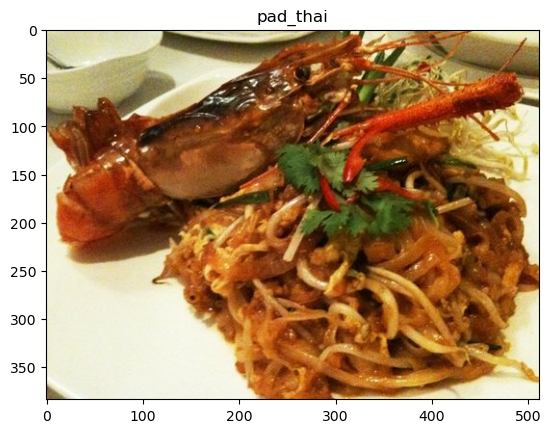

In [14]:
# Afficher une image du dataset TensorFlow
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])

##### Créer des fonctions de prétraitement pour nos données

##### Ce que nous savons sur nos données :

* Type de données 'uint8'
* Composé de tailles variées de tenseurs (images de tailles différentes)
* Non mises à l'échelle (les valeurs des pixels sont comprises entre 0 et 255)
* Ce que nous savons sur les modèles :

##### Données en 'float32'
* TensorFlow préfère que toutes les images d'un lot aient la même taille
* Mises à l'échelle (valeurs entre 0 et 1, également appelé normalisé)
* Avec cela en tête, nous avons plusieurs choses à aborder avec une fonction de prétraitement.

##### Comme nous allons utiliser EfficientNetBX pré-entraîné de tf.keras.applications, nous n'avons pas besoin de redimensionner nos données (ces architectures ont un redimensionnement intégré).

##### Notre fonction doit :

* Redimensionner toutes nos images à la même taille
* Convertir le type de données de nos tenseurs d'image de 'uint8' à 'float32'

In [15]:
# Créer une fonction pour le prétraitement des images
def preprocess_img(image, label, img_shape=244):
    """
    Convertir le type de données de l'image de 'uint8' à 'float32' et redimensionner l'image à (img_shape, img_shape, 3).
    """
    image = tf.image.resize(image, [img_shape, img_shape])  # Reshape target image
    return tf.cast(image, tf.float32), label

In [16]:
# Prétraiter une seule image échantillon et vérifier le résultat
preprocessed_img = preprocess_img(image, label)[0] # retourne un tuple et nous voulons seulement l'image
print(f"Image before preprocessing:\n {image[:2]}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print(f"###########################")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}")
print(f"Image shape: {preprocessed_img.shape}")
print(f"Image dtype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]
Image shape: (384, 512, 3)
Image dtype: <dtype: 'uint8'>
###########################
Image after preprocessing:
 [[[229.66031 228.66031 182.08653]
  [230.00269 229.28958 180.7158 ]
  [224.9142  224.9142  173.4224 ]
  ...
  [237.75494 231.47707 201.58101]
  [235.6259  233.38799 203.68315]
  [230.11931 236.02092 205.57011]]

 [[228.78413 228.64479 175.48085]
  [226.39359 226.39359 174.67227]
  [227.06    227.06    175.1308 ]
  ...
  [237.92068 232.17474 200.24554]
  [235.17233 233.49176 202.36893]
  [233.2896  239.19121 207.01909]]]
Image shape: (244, 244, 3)
Image dtype: <dtype: 'float32'>


##### Batcher et préparer les datasets
##### Nous allons maintenant rendre notre pipeline d'entrée de données vraiment rapide.

In [17]:
# Mapper la fonction de prétraitement sur les données d'entraînement (AUTOTUNE utilise autant de processus que possible)
# Prétraiter et batcher les données d'entraînement
train_data = train_data.map(lambda x, y: preprocess_img(x, y, img_shape=224), num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# Prétraiter et batcher les données de test
test_data = test_data.map(lambda x, y: preprocess_img(x, y, img_shape=224), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

##### Créer des callbacks pour le modèle
##### Nous allons créer plusieurs callbacks pour nous aider pendant l'entraînement du modèle :

* Callback TensorBoard pour enregistrer les résultats de l'entraînement (pour que nous puissions les visualiser plus tard si nécessaire)
* Callback ModelCheckpoint pour sauvegarder la progression de notre modèle après l'extraction des caractéristiques

In [19]:
# Créer le callback TensorBoard (importé depuis helper_functions.py)
from helper_functions import create_tensorboard_callback

# Sauvegarder les poids au lieu de sauvegarder tout le modèle, ce qui est plus rapide
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor="val_acc", 
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)
# verbose = 0, ne rien afficher si le modèle est sauvegardé ou non

### Configurer l'entraînement en précision mixte

In [20]:
# Activer l'entraînement en précision mixte
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Définir la politique de données globale en précision mixte
# Utiliser les types de données float16 et float32 pour accélérer les performances du modèle

In [21]:
mixed_precision.global_policy()

<FloatDTypePolicy "mixed_float16">

##### Construire un modèle d'extraction de caractéristiques

In [22]:
len(class_names)

101

In [23]:
from tensorflow.keras import layers

# Créer le modèle de base
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
# Geler les poids des paramètres du modèle de base
base_model.trainable = False

# Créer un modèle fonctionnel
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compiler le modèle
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

##### Vérifier les politiques dtype des couches : utilisons-nous la précision mixte ?

In [25]:
# Vérifier les attributs dtype_policy des couches de notre modèle
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <FloatDTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <FloatDTypePolicy "mixed_float16">
global_average_pooling2d True float32 <FloatDTypePolicy "mixed_float16">
dense True float32 <FloatDTypePolicy "mixed_float16">
softmax_float32 True float32 <FloatDTypePolicy "float32">


In [26]:
# Vérifier les attributs dtype_policy des couches du modèle EfficientV2NetB0
for layer in base_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <FloatDTypePolicy "mixed_float16">
rescaling False float32 <FloatDTypePolicy "mixed_float16">
normalization False float32 <FloatDTypePolicy "mixed_float16">
stem_conv False float32 <FloatDTypePolicy "mixed_float16">
stem_bn False float32 <FloatDTypePolicy "mixed_float16">
stem_activation False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_conv False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_bn False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_activation False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_conv False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_bn False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_activation False float32 <FloatDTypePolicy "mixed_float16">
block2a_project_conv False float32 <FloatDTypePolicy "mixed_float16">
block2a_project_bn False float32 <FloatDTypePolicy "mixed_float16">
block2b_expand_conv False float32 <FloatDTypePolicy "mixed_float16">
bloc

In [27]:
mixed_precision.global_policy()

<FloatDTypePolicy "mixed_float16">

##### Entraîner le modèle d'extraction de caractéristiques

In [28]:
# Entraîner le modèle d'extraction de caractéristiques avec des callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3, 
                                                     steps_per_epoch=len(train_data), 
                                                     validation_data=test_data, 
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs", 
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20241003-090308
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3742s 2s/step - accuracy: 0.4600 - loss: 2.3543 - val_accuracy: 0.6962 - val_loss: 1.1668
Epoch 2/3


C:\Users\anasa\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\anasa\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 168s 71ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6841 - val_loss: 1.1820
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3672s 2s/step - accuracy: 0.6586 - loss: 1.3329 - val_accuracy: 0.7142 - val_loss: 1.0480


In [29]:
# Évaluer le modèle sur l'ensemble du dataset de test
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 1159s 1s/step - accuracy: 0.7168 - loss: 1.0524


[1.0519026517868042, 0.7169108986854553]

In [30]:
# Sauvegarder le modèle localement (si vous utilisez Google Colab, le modèle sauvegardé sera supprimé lorsque l'instance Colab sera terminée)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [31]:
# Charger le modèle précédemment sauvegardé
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [32]:
# Vérifier les couches du modèle de base et voir quelle politique dtype elles utilisent
for layer in loaded_saved_model.layers[1].layers[:20]: # vérifier uniquement les 20 premières couches pour limiter la sortie
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <FloatDTypePolicy "mixed_float16">
rescaling False float32 <FloatDTypePolicy "mixed_float16">
normalization False float32 <FloatDTypePolicy "mixed_float16">
stem_conv False float32 <FloatDTypePolicy "mixed_float16">
stem_bn False float32 <FloatDTypePolicy "mixed_float16">
stem_activation False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_conv False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_bn False float32 <FloatDTypePolicy "mixed_float16">
block1a_project_activation False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_conv False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_bn False float32 <FloatDTypePolicy "mixed_float16">
block2a_expand_activation False float32 <FloatDTypePolicy "mixed_float16">
block2a_project_conv False float32 <FloatDTypePolicy "mixed_float16">
block2a_project_bn False float32 <FloatDTypePolicy "mixed_float16">
block2b_expand_conv False float32 <FloatDTypePolicy "mixed_float16">
block

In [33]:
# Vérifier les performances du modèle chargé (cela devrait être les mêmes que celles du modèle d'extraction de caractéristiques)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 1169s 1s/step - accuracy: 0.7166 - loss: 1.0528


[1.0519040822982788, 0.7169108986854553]

In [34]:
# Les résultats du modèle chargé doivent être égaux (ou du moins très proches) de ceux du modèle avant la sauvegarde
# Remarque : cela ne fonctionnera que si vous avez instancié des variables de résultats
# import numpy as np
# assert np.isclose(results_feature_extract_model, results_loaded_saved_model, rtol=1e-05, atol=1e-08).all()

In [35]:
# Obtenir un résumé de notre modèle téléchargé
loaded_saved_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,307,461 (24.06 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [36]:
# Configurer le callback EarlyStopping pour arrêter l'entraînement si la val_loss du modèle n'améliore pas pendant 3 époques
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",  # Surveiller la métrique val_loss
                                                  patience=3)  # Si la val_loss diminue pendant 3 époques d'affilée, arrêter l'entraînement

# Créer un callback ModelCheckpoint pour sauvegarder le meilleur modèle pendant le fine-tuning
checkpoint_path = "fine_tune_checkpoints/fine_tune_checkpoints.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [37]:
# Créer un callback de réduction du taux d'apprentissage
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,  # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1,  # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [38]:
# Compiler le modèle
loaded_saved_model.compile(loss="sparse_categorical_crossentropy",  # sparse_categorical_crossentropy car les labels ne sont pas one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001),  # 10x moins que le taux d'apprentissage par défaut
                        metrics=["accuracy"])

In [39]:
# Commencer le fine-tuning (pour toutes les couches)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, # Affiner pour un maximum de 100 époques
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # Validation pendant l'entraînement sur 15% des données de test
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # Garder trace des logs du modèle pendant l'entraînement
                                                                   model_checkpoint, # Sauvegarder uniquement le meilleur modèle pendant l'entraînement
                                                                   early_stopping, # Arrêter le modèle après X époques sans améliorations
                                                                   reduce_lr]) # Réduire le taux d'apprentissage après X époques sans améliorations

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20241003-114824
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3656s 2s/step - accuracy: 0.7011 - loss: 1.1496 - val_accuracy: 0.7381 - val_loss: 1.0137 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 167s 71ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7256 - val_loss: 1.0239 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3800s 2s/step - accuracy: 0.7087 - loss: 1.1279 - val_accuracy: 0.7336 - val_loss: 0.9921 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 181s 76ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7370 - val_loss: 0.9848 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 3849s 2s/step - accuracy: 0.7141 - loss: 1.1101 - val_accuracy: 0.7264 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9

In [40]:
# Sauvegarder le modèle localement
loaded_saved_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.keras")

In [41]:
# Charger le modèle fine-tuné depuis Google Storage et évaluer
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.keras")

In [42]:
# Obtenir un résumé du modèle (même architecture que ci-dessus)
loaded_fine_tuned_gs_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,307,461 (24.06 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [43]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 1214s 2s/step - accuracy: 0.7362 - loss: 0.9983


[0.9974470138549805, 0.7340593934059143]